<a href="https://colab.research.google.com/github/wangechi01-a/Land-Cover-Project/blob/main/Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas folium shapely keplerGl catboost lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached jupyter_packaging-0.12.3-py3-none-any.whl.metadata (7.7 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached async_lru-2.0.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached jupyter_lsp-2.2.5-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.15.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached jupyter_

In [2]:
!pip install iterative-stratification

#Importing the necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import  pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from keplergl import KeplerGl
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss


#Load the Datasets

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Land Cover Classification Project/train_land_cover_assignment.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Land Cover Classification Project/test_land_cover_assignment.csv')
ss = pd.read_csv('/content/drive/MyDrive/Land Cover Classification Project/sample_submission_assignment.csv')
grid_civ = pd.read_csv('/content/drive/MyDrive/Land Cover Classification Project/CIV_grids.csv')

In [5]:
train = gpd.GeoDataFrame(
    train_df,
    geometry=gpd.points_from_xy(train_df.lon, train_df.lat)
)


In [6]:
test = gpd.GeoDataFrame(
    test_df,
    geometry=gpd.points_from_xy(test_df.lon, test_df.lat)
)



Read the loaded datasets

In [7]:
train.head()

subid       lat       lon building cropland wcover  bcount             x  \
0  1548937  7.387687 -4.780390       No       No   >60%     0.0 -2.714375e+06   
1  1548936  8.690266 -5.770243       No      Yes   <30%     0.0 -2.812625e+06   
2  1548935  8.518763 -2.808147       No      Yes   <30%     0.0 -2.495125e+06   
3  1548934  8.637725 -3.048867       No       No   <30%     0.0 -2.520375e+06   
4  1548933  7.993474 -6.044227       No       No   <30%     0.0 -2.846625e+06   

               y    bd20  ...         nppm         npps   ph20      sirm  \
0  321874.969864  1.4900  ...  5052.299805   853.451416  6.100  0.717054   
1  474124.973063  1.2925  ...  5316.700195   933.074402  5.575  0.717198   
2  440374.986977  1.3050  ...  4519.700195  1186.817627  5.850  0.717171   
3  454875.008083  1.3275  ...  3439.800049   910.979309  5.950  0.718244   
4  396624.944149  1.4200  ...  5226.899902   802.602661  5.800  0.716653   

       sirs     slope  snd20  soc20        tim                  geometry  
0  0.008259  0.729217  66.75  12.25   8.079082  POINT (-4.78039 7.38769)  
1  0.007242  1.086981  51.50  14.25   9.549431  POINT (-5.77024 8.69027)  
2  0.006744  1.159993  47.00  14.50  10.523131  POINT (-2.80815 8.51876)  
3  0.007917  2.471163  62.75  12.75   9.305363  POINT (-3.04887 8.63772)  
4  0.007022  0.259416  55.00  13.25  15.732859  POINT (-6.04423 7.99347)  

[5 rows x 50 columns]

In [8]:
test.head()

subid       lat       lon  bcount             x              y    bd20  \
0  1548905  4.824505 -7.522892     NaN -3.023125e+06   44125.021587  1.4075   
1  1548829  5.457730 -5.010404     NaN -2.749125e+06  104624.973824  1.6350   
2  1548811  5.081743 -7.148626     NaN -2.981625e+06   71625.015246  1.5825   
3  1548806  5.673164 -4.171414     NaN -2.657375e+06  125374.968207  1.7350   
4  1548798  4.665885 -7.040600     NaN -2.971875e+06   23875.013622  1.5925   

   bio1  bio12  bio7  ...          nppm         npps   ph20      sirm  \
0   250   2564    46  ...  12909.700195   870.217346  5.025  0.719068   
1   261   1378    71  ...  12288.299805   839.143616  4.850  0.724049   
2   247   1704    46  ...  13374.500000   763.726135  5.100  0.720274   
3   261   1700    68  ...  11717.200195   814.182434  5.125  0.724026   
4   259   1724    61  ...   3474.800049  1809.494385  4.950  0.716632   

       sirs     slope  snd20  soc20        tim                  geometry  
0  0.007398  4.093175  64.50  23.50   9.168183   POINT (-7.52289 4.8245)  
1  0.007270  0.487844  65.75  13.00   7.896024   POINT (-5.0104 5.45773)  
2  0.006467  2.113945  52.00  23.25   7.606022  POINT (-7.14863 5.08174)  
3  0.007111  0.962922  59.75  15.00   8.471351  POINT (-4.17141 5.67316)  
4  0.007030  0.779259  70.50  15.75  13.725027   POINT (-7.0406 4.66588)  

[5 rows x 47 columns]

In [9]:
ss.head(3)

subid  building_prob  cropland_prob  wcover_prob
0  1548905           0.33           0.33         0.34
1  1548829           0.33           0.33         0.34
2  1548811           0.33           0.33         0.34

In [10]:
grid_civ.head(3)

Variable name                                        Description  \
0          bd20          Topsoil bulk density (Mg/m^3, soil fines)   
1          bio1   Mean annual temperature (deg. C * 10, 1979-2013)   
2          bio7  Mean annual temperature range (deg. C * 10, 19...   

  Data source                    Original data link  
0   SoilGrids                 https://soilgrids.org  
1      Chelsa  http://chelsa-climate.org/downloads/  
2      Chelsa  http://chelsa-climate.org/downloads/

In [11]:
train.shape,test.shape

((15856, 50), (35, 47))

In [12]:
train.columns

Index(['subid', 'lat', 'lon', 'building', 'cropland', 'wcover', 'bcount', 'x',
       'y', 'bd20', 'bio1', 'bio12', 'bio7', 'bio15', 'cec20', 'dipa', 'dni',
       'dnlt', 'dnpa', 'dor1', 'dor2', 'fpara', 'fpars', 'lcc10', 'lcc11',
       'lcc12', 'lcc13', 'lcc14', 'lcc21', 'lcc8', 'lcc9', 'lstd', 'lstn',
       'mb1', 'mb2', 'mb3', 'mb7', 'mdem', 'mlat', 'mlon', 'nppm', 'npps',
       'ph20', 'sirm', 'sirs', 'slope', 'snd20', 'soc20', 'tim', 'geometry'],
      dtype='object')

In [13]:
categorical_cols = train.select_dtypes(include="object").columns
categorical_cols

Index(['building', 'cropland', 'wcover'], dtype='object')

In [14]:
numerical_cols = train.select_dtypes(exclude="object").columns
numerical_cols = test.select_dtypes(exclude="object").columns
numerical_cols

Index(['subid', 'lat', 'lon', 'bcount', 'x', 'y', 'bd20', 'bio1', 'bio12',
       'bio7', 'bio15', 'cec20', 'dipa', 'dni', 'dnlt', 'dnpa', 'dor1', 'dor2',
       'fpara', 'fpars', 'lcc10', 'lcc11', 'lcc12', 'lcc13', 'lcc14', 'lcc21',
       'lcc8', 'lcc9', 'lstd', 'lstn', 'mb1', 'mb2', 'mb3', 'mb7', 'mdem',
       'mlat', 'mlon', 'nppm', 'npps', 'ph20', 'sirm', 'sirs', 'slope',
       'snd20', 'soc20', 'tim', 'geometry'],
      dtype='object')

In [15]:
train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15856 entries, 0 to 15855
Data columns (total 50 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   subid     15856 non-null  int64   
 1   lat       15856 non-null  float64 
 2   lon       15856 non-null  float64 
 3   building  15856 non-null  object  
 4   cropland  15856 non-null  object  
 5   wcover    15856 non-null  object  
 6   bcount    15856 non-null  float64 
 7   x         15856 non-null  float64 
 8   y         15856 non-null  float64 
 9   bd20      15811 non-null  float64 
 10  bio1      15856 non-null  int64   
 11  bio12     15856 non-null  int64   
 12  bio7      15856 non-null  int64   
 13  bio15     15856 non-null  int64   
 14  cec20     15811 non-null  float64 
 15  dipa      15856 non-null  float64 
 16  dni       15856 non-null  float64 
 17  dnlt      15856 non-null  float64 
 18  dnpa      15856 non-null  float64 
 19  dor1      15856 non-null  float64 
 20

In [16]:
test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   subid     35 non-null     int64   
 1   lat       35 non-null     float64 
 2   lon       35 non-null     float64 
 3   bcount    0 non-null      float64 
 4   x         35 non-null     float64 
 5   y         35 non-null     float64 
 6   bd20      35 non-null     float64 
 7   bio1      35 non-null     int64   
 8   bio12     35 non-null     int64   
 9   bio7      35 non-null     int64   
 10  bio15     35 non-null     int64   
 11  cec20     35 non-null     float64 
 12  dipa      35 non-null     float64 
 13  dni       35 non-null     float64 
 14  dnlt      35 non-null     float64 
 15  dnpa      35 non-null     float64 
 16  dor1      35 non-null     float64 
 17  dor2      35 non-null     float64 
 18  fpara     35 non-null     float64 
 19  fpars     35 non-null     float64 
 20  lcc1

In [17]:
train.isnull().sum() * 100 / len(train)


subid       0.000000
lat         0.000000
lon         0.000000
building    0.000000
cropland    0.000000
wcover      0.000000
bcount      0.000000
x           0.000000
y           0.000000
bd20        0.283804
bio1        0.000000
bio12       0.000000
bio7        0.000000
bio15       0.000000
cec20       0.283804
dipa        0.000000
dni         0.000000
dnlt        0.000000
dnpa        0.000000
dor1        0.000000
dor2        0.000000
fpara       0.000000
fpars       0.000000
lcc10       0.000000
lcc11       0.000000
lcc12       0.000000
lcc13       0.000000
lcc14       0.000000
lcc21       0.000000
lcc8        0.000000
lcc9        0.000000
lstd        0.119828
lstn        0.119828
mb1         0.006307
mb2         0.006307
mb3         0.006307
mb7         0.006307
mdem        0.000000
mlat        0.000000
mlon        0.000000
nppm        0.000000
npps        0.000000
ph20        0.283804
sirm        0.000000
sirs        0.000000
slope       0.000000
snd20       0.283804
soc20       0.283804
tim         0.006307
geometry    0.000000
dtype: float64

In [18]:
test.isnull().sum() * 100 / len(test)


subid         0.0
lat           0.0
lon           0.0
bcount      100.0
x             0.0
y             0.0
bd20          0.0
bio1          0.0
bio12         0.0
bio7          0.0
bio15         0.0
cec20         0.0
dipa          0.0
dni           0.0
dnlt          0.0
dnpa          0.0
dor1          0.0
dor2          0.0
fpara         0.0
fpars         0.0
lcc10         0.0
lcc11         0.0
lcc12         0.0
lcc13         0.0
lcc14         0.0
lcc21         0.0
lcc8          0.0
lcc9          0.0
lstd          0.0
lstn          0.0
mb1           0.0
mb2           0.0
mb3           0.0
mb7           0.0
mdem          0.0
mlat          0.0
mlon          0.0
nppm          0.0
npps          0.0
ph20          0.0
sirm          0.0
sirs          0.0
slope         0.0
snd20         0.0
soc20         0.0
tim           0.0
geometry      0.0
dtype: float64

## Filling in Missing values

In [19]:
# Function to remove NaNs: Drop columns with >70% NaNs, fill remaining with 0

def remove_nans(train, thresh=0.7):
    def nans_rate(train, col):
        return train[col].isna().sum() / train.shape[0]

    for col in train.columns:
        if nans_rate(train, col) >= thresh:
            train.drop(col, axis=1, inplace=True)
        else:
            train[col] = train[col].fillna(0)
    return train

# Apply NaN handling to train and test sets
train = remove_nans(train, 0.7)
test = remove_nans(test, 0.7)

train.shape, test.shape


((15856, 50), (35, 46))

In [20]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

subid       15856
lat         15833
lon         15827
building        2
cropland        2
wcover          3
bcount        156
x           15856
y           15856
bd20          285
bio1           66
bio12        1304
bio7           63
bio15         145
cec20          92
dipa        13306
dni          1996
dnlt         1785
dnpa         3202
dor1         3690
dor2          737
fpara       10902
fpars       15247
lcc10          65
lcc11          58
lcc12          41
lcc13          65
lcc14          28
lcc21          64
lcc8           35
lcc9           65
lstd          476
lstn          219
mb1           777
mb2          1350
mb3           861
mb7          1131
mdem          693
mlat        15841
mlon        15850
nppm        14459
npps        15652
ph20           77
sirm        14688
sirs        15326
slope        2174
snd20         168
soc20         176
tim         15633
geometry    15856
dtype: int64

## Visualization

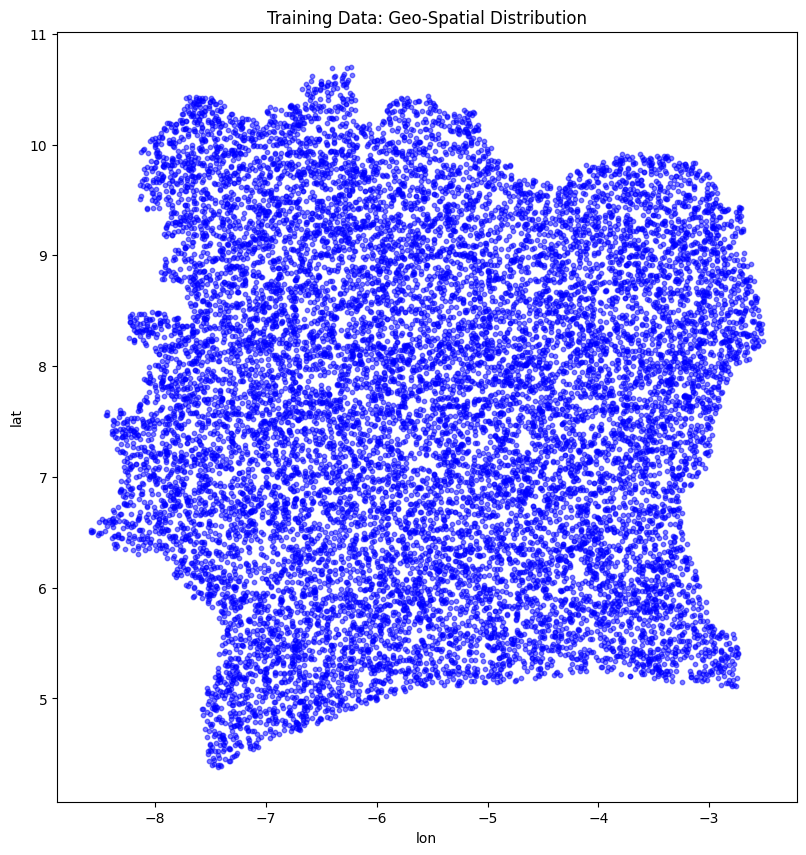

In [21]:
# Plot points of the train dataset on a map
train.plot(
    figsize=(10, 10),
    color="blue",
    alpha=0.5,
    markersize=10,
    legend=True
)
plt.title("Training Data: Geo-Spatial Distribution")
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

Visualization of the target columns

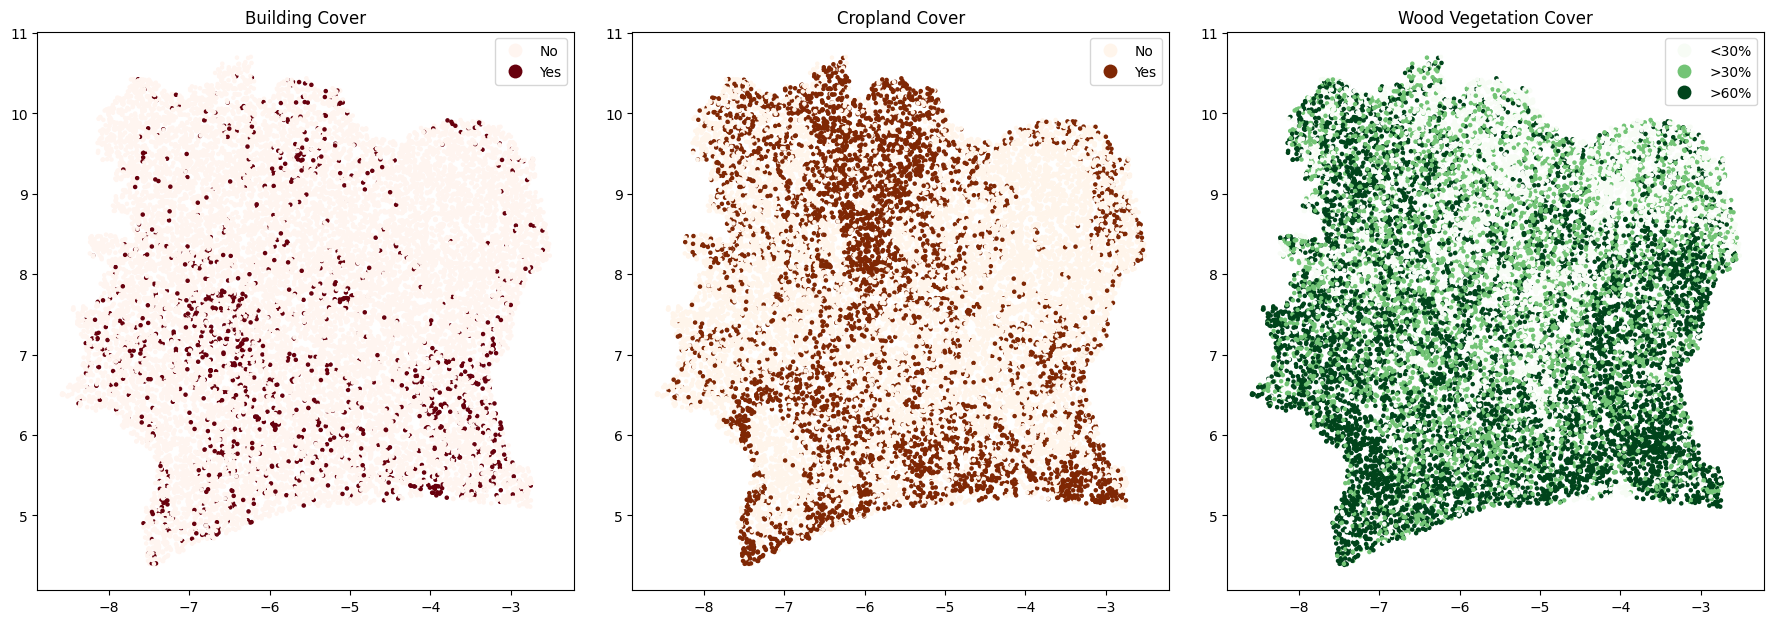

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Building Cover
train.plot(column='building', cmap='Reds', legend=True, markersize=5, ax=ax[0])
ax[0].set_title("Building Cover")

# Cropland Cover
train.plot(column='cropland', cmap='Oranges', legend=True, markersize=5, ax=ax[1])
ax[1].set_title("Cropland Cover")

# Woody Vegetation Cover
train.plot(column='wcover', cmap='Greens', legend=True, markersize=5, ax=ax[2])
ax[2].set_title("Wood Vegetation Cover")

plt.tight_layout()
plt.show()


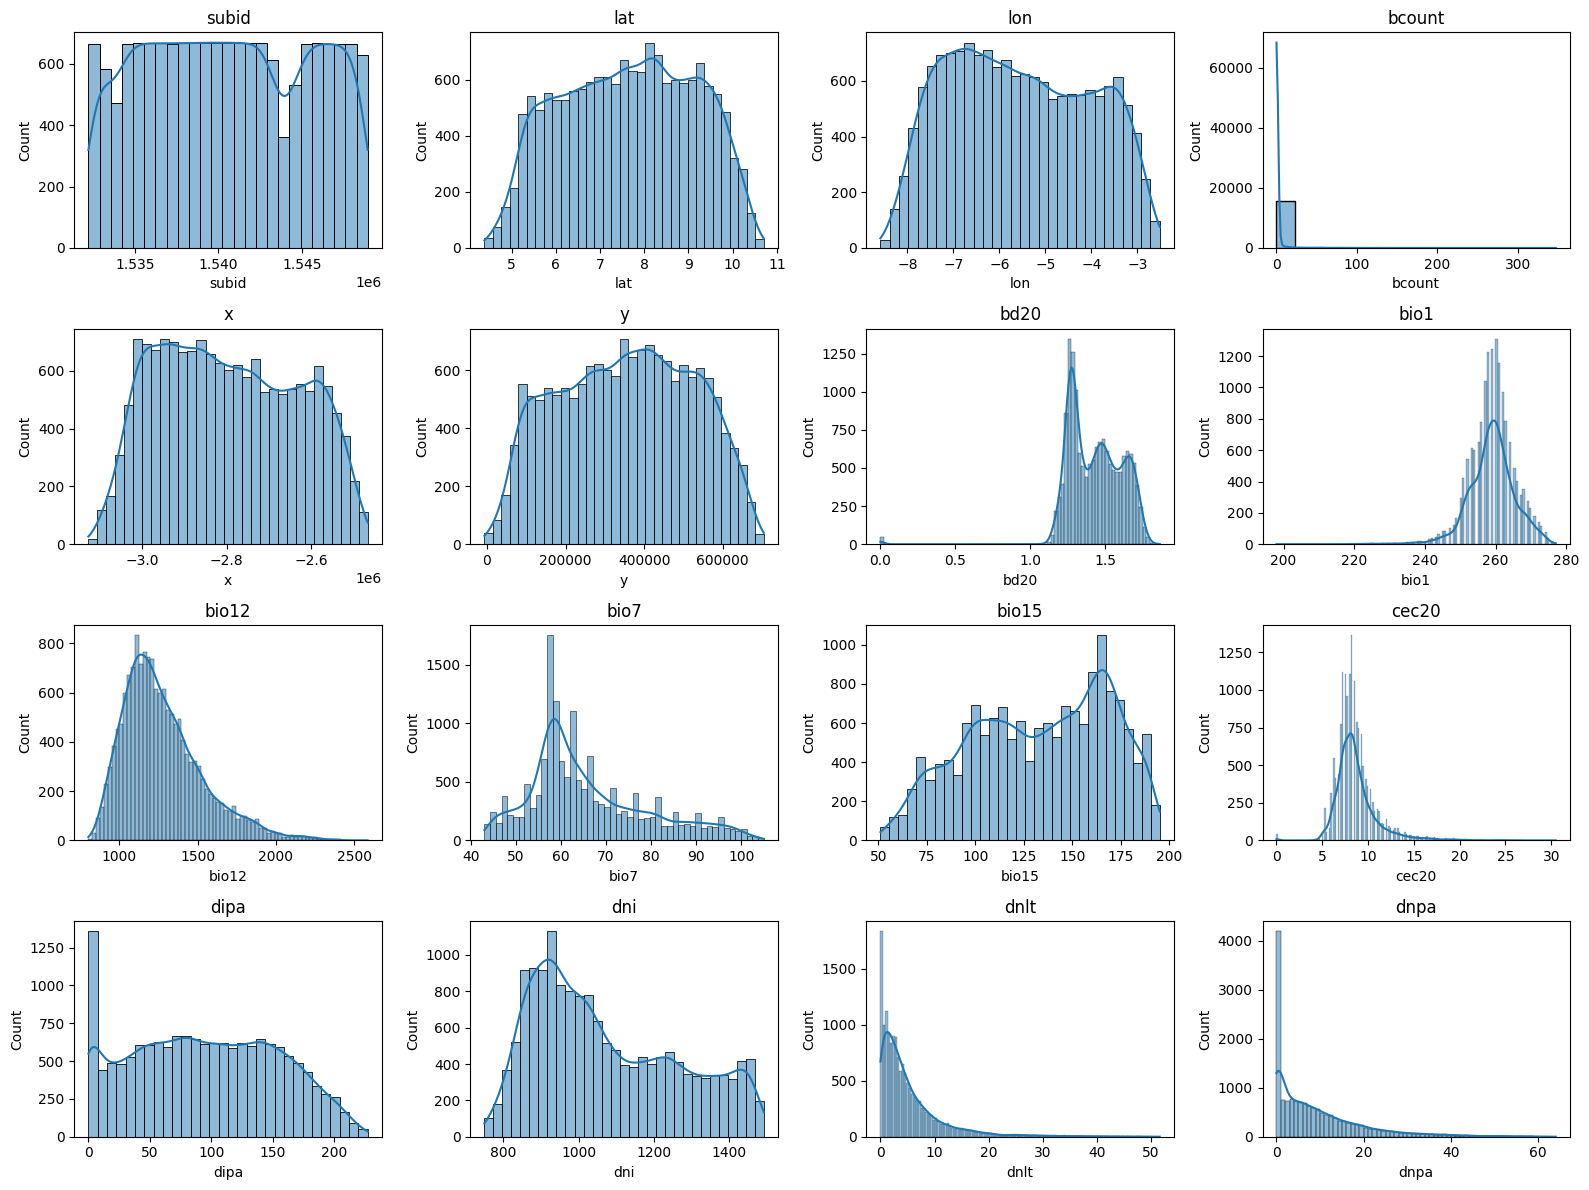

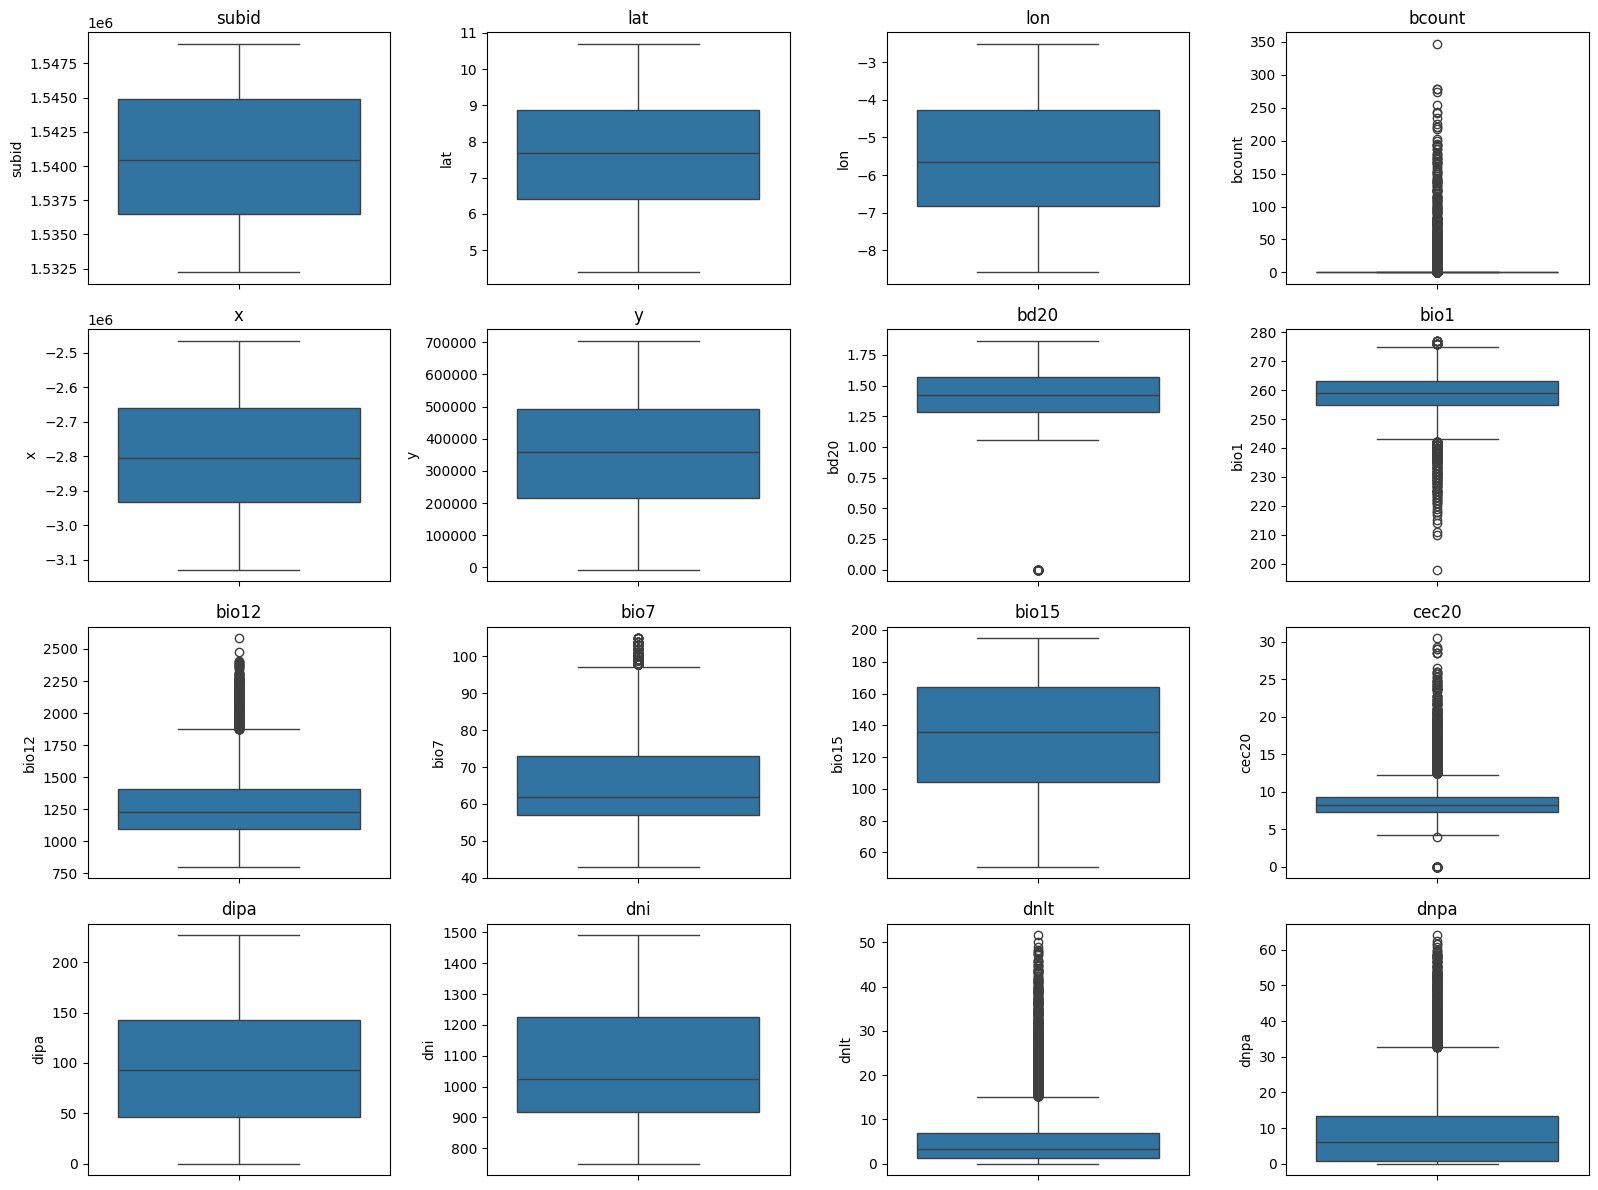

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:16]):
    sns.histplot(data=train, x=col, kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:16]):
    sns.boxplot(y=train[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Conversion of  cover column to yes for values >60% and no <30% and >30%

In [24]:
def rename_wcover(value):
    """Map wcover values to 'Yes' for >60% and 'No' for <30% and >30%."""
    mapping = {">60%": "Yes", "<30%": "No", ">30%": "No"}
    return mapping.get(value, "Unknown")
# Apply function to transform wcover
train['wcover'] = train['wcover'].apply(rename_wcover)

train.head()


subid       lat       lon building cropland wcover  bcount             x  \
0  1548937  7.387687 -4.780390       No       No    Yes     0.0 -2.714375e+06   
1  1548936  8.690266 -5.770243       No      Yes     No     0.0 -2.812625e+06   
2  1548935  8.518763 -2.808147       No      Yes     No     0.0 -2.495125e+06   
3  1548934  8.637725 -3.048867       No       No     No     0.0 -2.520375e+06   
4  1548933  7.993474 -6.044227       No       No     No     0.0 -2.846625e+06   

               y    bd20  ...         nppm         npps   ph20      sirm  \
0  321874.969864  1.4900  ...  5052.299805   853.451416  6.100  0.717054   
1  474124.973063  1.2925  ...  5316.700195   933.074402  5.575  0.717198   
2  440374.986977  1.3050  ...  4519.700195  1186.817627  5.850  0.717171   
3  454875.008083  1.3275  ...  3439.800049   910.979309  5.950  0.718244   
4  396624.944149  1.4200  ...  5226.899902   802.602661  5.800  0.716653   

       sirs     slope  snd20  soc20        tim                  geometry  
0  0.008259  0.729217  66.75  12.25   8.079082  POINT (-4.78039 7.38769)  
1  0.007242  1.086981  51.50  14.25   9.549431  POINT (-5.77024 8.69027)  
2  0.006744  1.159993  47.00  14.50  10.523131  POINT (-2.80815 8.51876)  
3  0.007917  2.471163  62.75  12.75   9.305363  POINT (-3.04887 8.63772)  
4  0.007022  0.259416  55.00  13.25  15.732859  POINT (-6.04423 7.99347)  

[5 rows x 50 columns]

Visualizing the Conversion of wcover column to yes for values >60% and no <30% and >30%

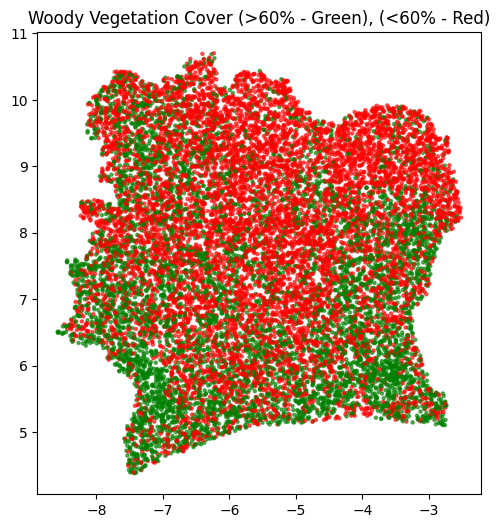

In [25]:

# Define colors for Yes/No
color_map = {'Yes': 'green', 'No': 'red'}

fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, color=train['wcover'].map(color_map), markersize=5, alpha=0.6)
ax.set_title("Woody Vegetation Cover (>60% - Green), (<60% - Red)")
plt.show()


Labdel encoding the categorical target columns to numerical columns

In [26]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(df, cols):
    for col in cols:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

# Apply encoding
target_cols = ['building', 'cropland', 'wcover']
train_gdf = encode_labels(train, target_cols)


Checking for correlation between the target columns and the other numerical columns;
This helps us see the positive and negative corelated columns making it easy to identify the most influential features for modeling

Correlations for Target: building
Positively Correlated Features:
dnpa        0.004201
lcc14       0.009333
sirs        0.014728
dipa        0.017297
lcc10       0.019622
fpara       0.019848
subid       0.026588
cropland    0.026760
lcc9        0.044992
fpars       0.048306
bio12       0.065954
bd20        0.084768
mb7         0.093088
snd20       0.094245
mb3         0.110041
mb2         0.138462
mb1         0.141040
bcount      0.458246
lcc21       0.465825
building    1.000000
Name: building, dtype: float64 

Negatively Correlated Features:
dor2     -0.117358
npps     -0.116051
bio15    -0.113197
mlat     -0.109856
lat      -0.109856
y        -0.109473
dni      -0.083172
mdem     -0.079094
dnlt     -0.074267
dor1     -0.067155
bio7     -0.064466
wcover   -0.050841
tim      -0.036214
lcc13    -0.031330
bio1     -0.029743
slope    -0.027819
ph20     -0.027320
lstd     -0.022091
cec20    -0.017921
lstn     -0.016170
sirm     -0.015308
x        -0.008605
soc20    -0.005033
lcc12    -0.

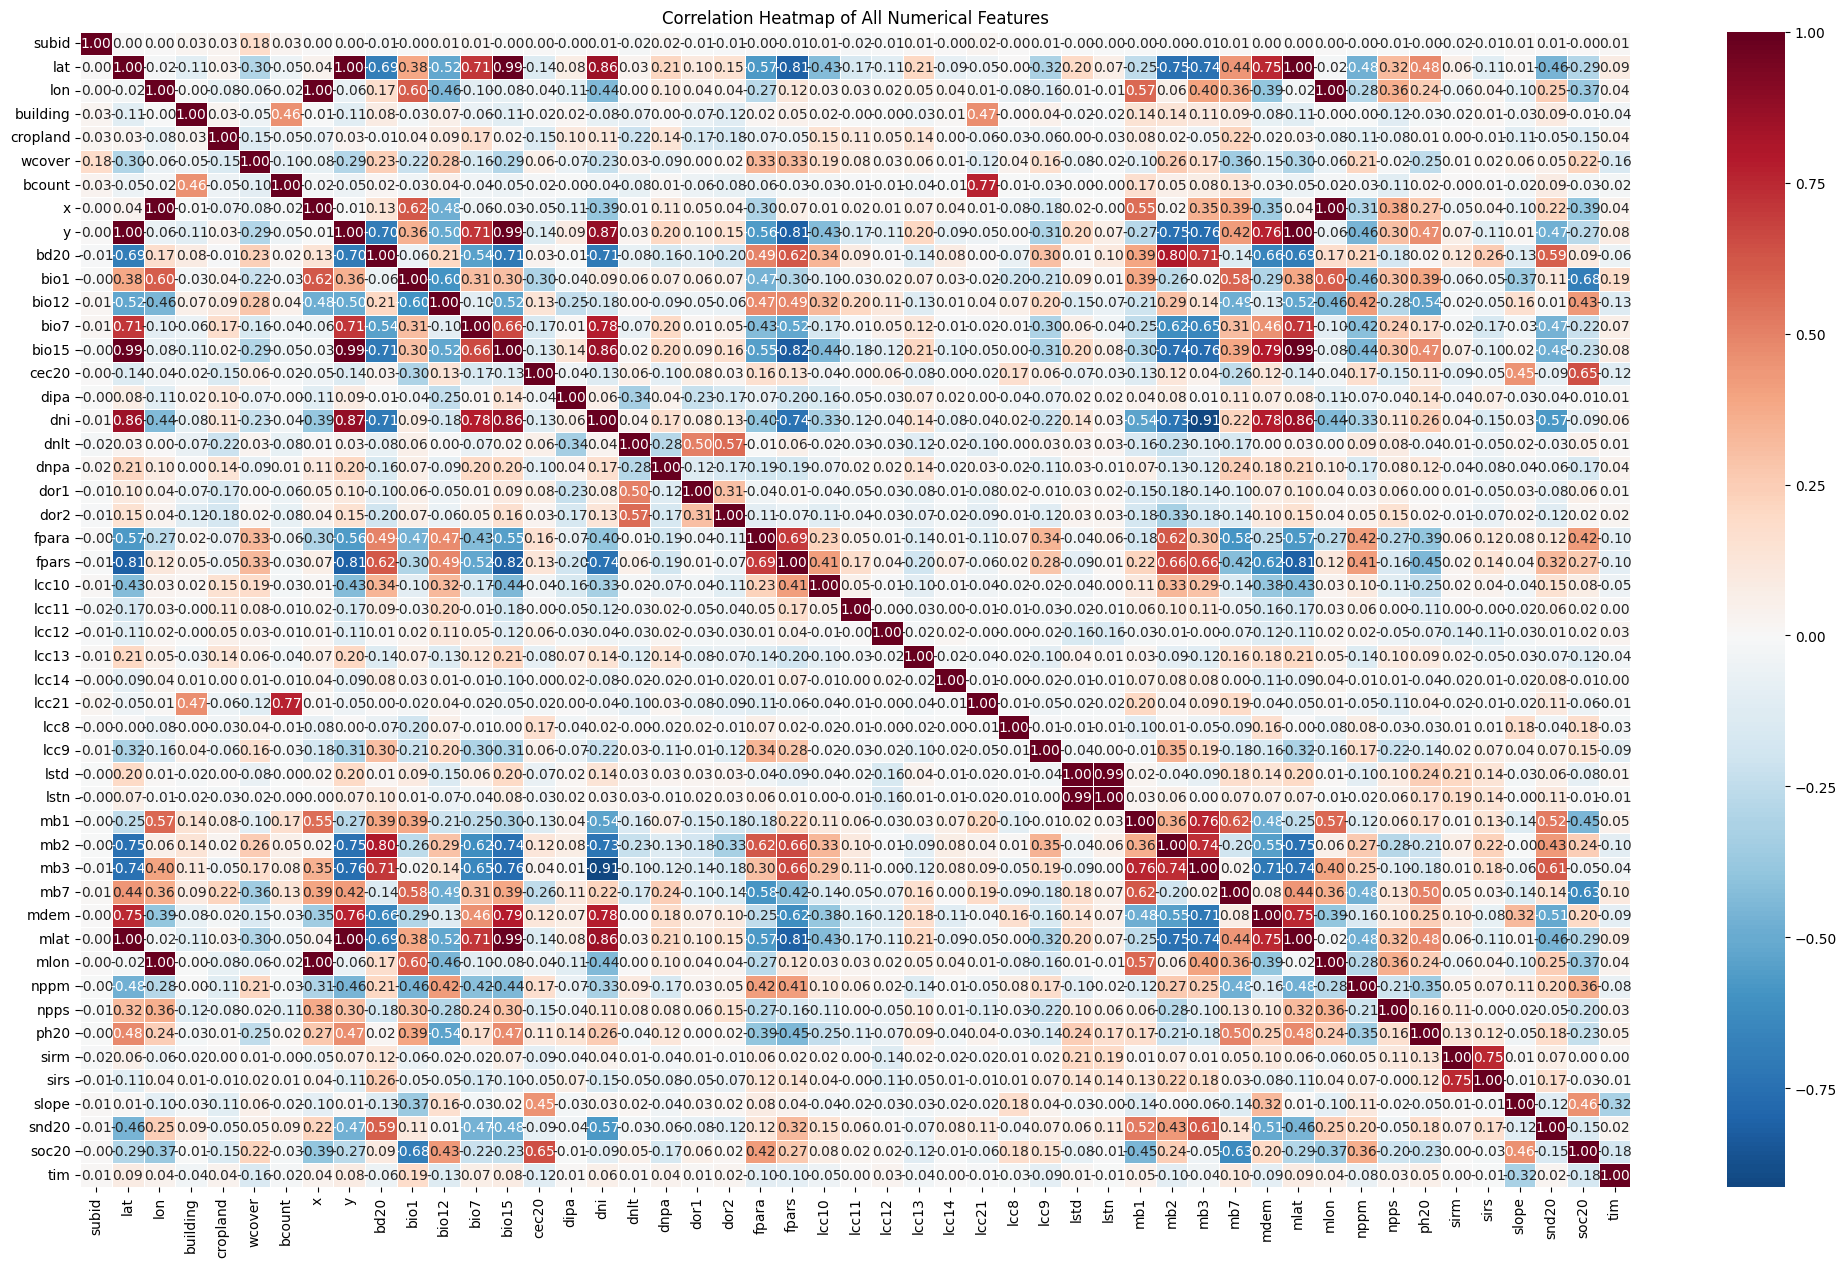

In [27]:
# Drop geometry column before calculating correlation
train_for_corr = train.drop(columns=['geometry'])

# Compute correlation matrix
correlation_matrix = train_for_corr.corr()
target_correlations = {}


for target in target_cols:
    # Extract correlations with the current target
    target_corr = correlation_matrix[target].sort_values()

    positive_corr = target_corr[target_corr > 0]
    negative_corr = target_corr[target_corr < 0]


    target_correlations[target] = {
      "positive": positive_corr,
      "negative": negative_corr
    }

    # Print positive and negative correlations
    print(f"Correlations for Target: {target}")
    print("Positively Correlated Features:")
    print(positive_corr, "\n")
    print("Negatively Correlated Features:")
    print(negative_corr, "\n")


# Set up the figure
plt.figure(figsize=(25, 15))

# Plot heatmap with positive and negative correlations
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdBu_r',
            linewidths=0.5,
            fmt=".2f",
            center=0)
plt.title("Correlation Heatmap of All Numerical Features")
plt.show()

In [28]:
train.head()

subid       lat       lon  building  cropland  wcover  bcount  \
0  1548937  7.387687 -4.780390         0         0       1     0.0   
1  1548936  8.690266 -5.770243         0         1       0     0.0   
2  1548935  8.518763 -2.808147         0         1       0     0.0   
3  1548934  8.637725 -3.048867         0         0       0     0.0   
4  1548933  7.993474 -6.044227         0         0       0     0.0   

              x              y    bd20  ...         nppm         npps   ph20  \
0 -2.714375e+06  321874.969864  1.4900  ...  5052.299805   853.451416  6.100   
1 -2.812625e+06  474124.973063  1.2925  ...  5316.700195   933.074402  5.575   
2 -2.495125e+06  440374.986977  1.3050  ...  4519.700195  1186.817627  5.850   
3 -2.520375e+06  454875.008083  1.3275  ...  3439.800049   910.979309  5.950   
4 -2.846625e+06  396624.944149  1.4200  ...  5226.899902   802.602661  5.800   

       sirm      sirs     slope  snd20  soc20        tim  \
0  0.717054  0.008259  0.729217  66.75  12.25   8.079082   
1  0.717198  0.007242  1.086981  51.50  14.25   9.549431   
2  0.717171  0.006744  1.159993  47.00  14.50  10.523131   
3  0.718244  0.007917  2.471163  62.75  12.75   9.305363   
4  0.716653  0.007022  0.259416  55.00  13.25  15.732859   

                   geometry  
0  POINT (-4.78039 7.38769)  
1  POINT (-5.77024 8.69027)  
2  POINT (-2.80815 8.51876)  
3  POINT (-3.04887 8.63772)  
4  POINT (-6.04423 7.99347)  

[5 rows x 50 columns]

## Feature Engineering

In [29]:
def feature_engineering(train, test):
    # Concatenate train and test data
    data = pd.concat([train, test], axis=0).reset_index(drop=True)

    # Target and Main Columns
    target_cols = ['building', 'cropland', 'wcover']

    # Feature Interaction
    data['lat_lon_interaction'] = data['lat'] * data['lon']
    data['bcount_bio1_interaction'] = data['bcount'] * data['bio1']
    data['bio_water_balance'] = data['bio12'] - data['bio7']
    data['bio_mean'] = data[['bio1', 'bio12', 'bio7', 'bio15']].mean(axis=1)

    for col in ['bcount', 'bio1', 'bio12', 'bio7', 'bio15', 'slope', 'soc20']:
        data[f'log_{col}'] = np.log1p(data[col])

    data['lat_squared'] = data['lat'] ** 2
    data['lon_squared'] = data['lon'] ** 2
    data['bcount_squared'] = data['bcount'] ** 2
    data['bio12_squared'] = data['bio12'] ** 2
    data['bio7_squared'] = data['bio7'] ** 2
    data['bio1_cubed'] = data['bio1'] ** 3
    data['bio12_cubed'] = data['bio12'] ** 3

    data['bio1_bio12_ratio'] = data['bio1'] / (data['bio12'] + 1e-6)
    data['bcount_bio7_ratio'] = data['bcount'] / (data['bio7'] + 1e-6)

    data['bio12_slope_diff'] = data['bio12'] - data['slope']
    data['bio7_soc20_diff'] = data['bio7'] - data['soc20']

    return data


In [30]:
data = feature_engineering(train, test)

main_cols = data.columns.difference(["subid", "geometry"] + target_cols)
# Split data back into train and test sets after feature engineering
train = data.loc[:train.shape[0] - 1, :].copy()
test = data.loc[train.shape[0]:, :].copy()
test.drop(target_cols, axis=1, inplace=True)

# Extract Features & Targets
X = train[main_cols].values
y = train[target_cols].values

# Initialize multilabel stratified split
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)

models = {}

# Train-Test Split
for train_idx, valid_idx in mskf.split(X, y):
    train_features, valid_features = X[train_idx], X[valid_idx]
    train_y, valid_y = y[train_idx], y[valid_idx]
    break

for i, target in enumerate(target_cols):
    print(f"Training model for {target}...")

    train_target = train_y[:, i]
    valid_target = valid_y[:, i]

    # Apply SMOTE to handle class imbalance for the current target
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    train_features_resampled, train_target_resampled = smote.fit_resample(
        train_features, train_target
    )
    print(f"Class distribution after SMOTE for {target}: {Counter(train_target_resampled)}")

    # Compute class weights for the current target
    class_counts = np.bincount(train_target_resampled.astype(int))
    total_samples = len(train_target_resampled)
    class_weights = {
        i: total_samples / (len(class_counts) * class_counts[i])
        for i in range(len(class_counts))
    }

    # Train CatBoost model
    model = CatBoostClassifier(
        random_state=42,
        verbose=200,
        early_stopping_rounds=500,
        class_weights=list(class_weights.values())
    )

    model.fit(train_features_resampled, train_target_resampled, eval_set=[(valid_features, valid_target)])


Training model for building...
Class distribution after SMOTE for building: Counter({0.0: 11631, 1.0: 11631})
Learning rate set to 0.06894
0:	learn: 0.4732394	test: 0.4713603	best: 0.4713603 (0)	total: 71.1ms	remaining: 1m 11s
200:	learn: 0.0006103	test: 0.0051508	best: 0.0050244 (69)	total: 3.67s	remaining: 14.6s
400:	learn: 0.0006094	test: 0.0051489	best: 0.0050244 (69)	total: 7.04s	remaining: 10.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.005024404534
bestIteration = 69

Shrink model to first 70 iterations.
Training model for cropland...
Class distribution after SMOTE for cropland: Counter({1.0: 8486, 0.0: 8486})
Learning rate set to 0.063775
0:	learn: 0.6684965	test: 0.6715705	best: 0.6715705 (0)	total: 37.8ms	remaining: 37.7s
200:	learn: 0.3587992	test: 0.4685178	best: 0.4685118 (199)	total: 3.49s	remaining: 13.9s
400:	learn: 0.2909884	test: 0.4582700	best: 0.4581769 (392)	total: 6.89s	remaining: 10.3s
600:	learn: 0.2464783	test: 0.4575576	best: 0.45695

<ipython-input-31-4caf79d10bcb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_y[:, i], ax=axes[i], palette="plasma")
<ipython-input-31-4caf79d10bcb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_y[:, i], ax=axes[i], palette="plasma")
<ipython-input-31-4caf79d10bcb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_y[:, i], ax=axes[i], palette="plasma")


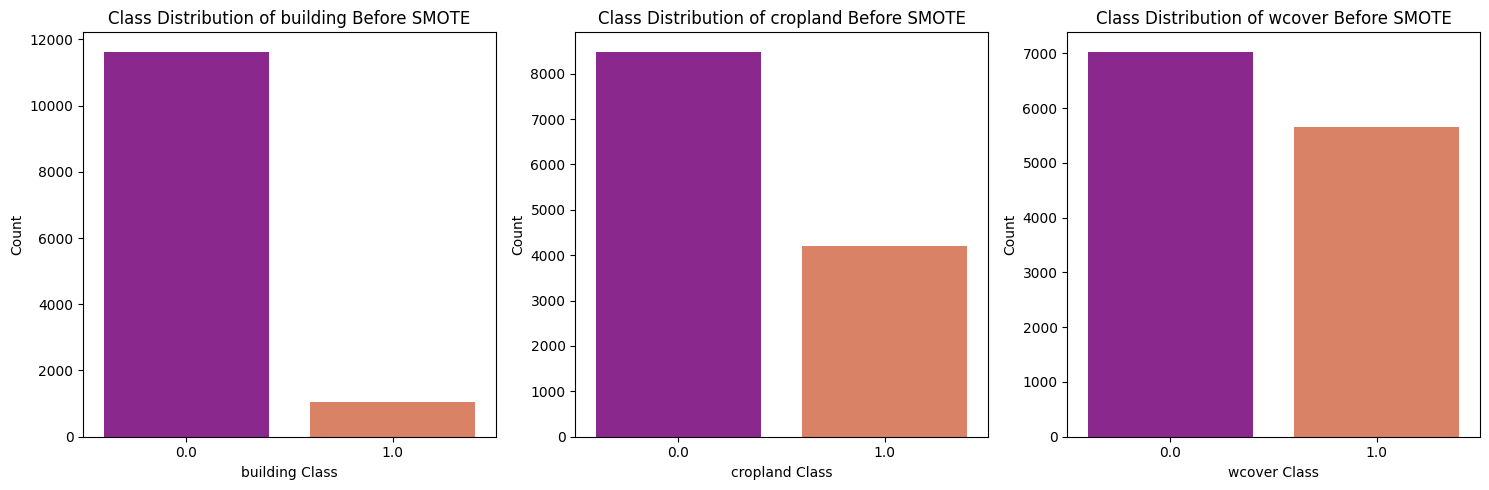

<ipython-input-31-4caf79d10bcb>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_target_resampled, ax=axes[i], palette="plasma")
<ipython-input-31-4caf79d10bcb>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_target_resampled, ax=axes[i], palette="plasma")
<ipython-input-31-4caf79d10bcb>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_target_resampled, ax=axes[i], palette="plasma")


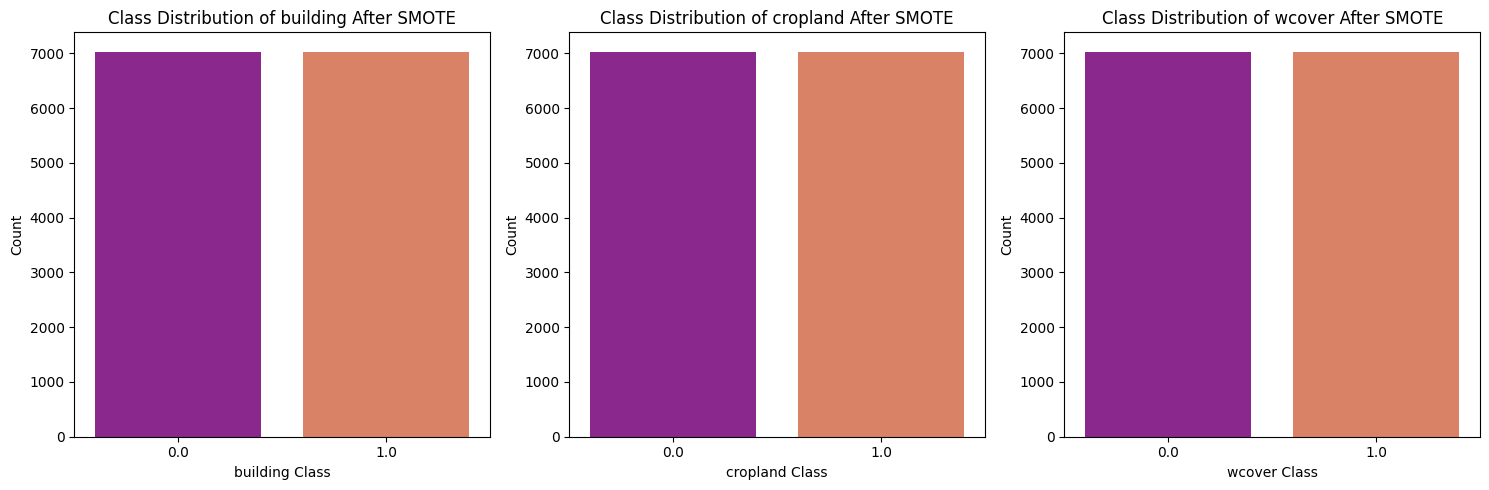

Class distribution before SMOTE:
building: Counter({0.0: 11631, 1.0: 1053})
cropland: Counter({0.0: 8486, 1.0: 4198})
wcover: Counter({0.0: 7034, 1.0: 5650})

Class distribution after SMOTE:
building: Counter({0.0: 7034, 1.0: 7034})
cropland: Counter({0.0: 7034, 1.0: 7034})
wcover: Counter({0.0: 7034, 1.0: 7034})


In [31]:
# Before Resampling
fig, axes = plt.subplots(1, len(target_cols), figsize=(5 * len(target_cols), 5))

for i, target in enumerate(target_cols):
    sns.countplot(x=train_y[:, i], ax=axes[i], palette="plasma")
    axes[i].set_title(f"Class Distribution of {target} Before SMOTE")
    axes[i].set_xlabel(f"{target} Class")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

# After Resampling
fig, axes = plt.subplots(1, len(target_cols), figsize=(5 * len(target_cols), 5))

for i, target in enumerate(target_cols):
    sns.countplot(x=train_target_resampled, ax=axes[i], palette="plasma")
    axes[i].set_title(f"Class Distribution of {target} After SMOTE")
    axes[i].set_xlabel(f"{target} Class")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print class distributions before and after SMOTE
print("Class distribution before SMOTE:")
for i, target in enumerate(target_cols):
    print(f"{target}:", Counter(train_y[:, i]))

print("\nClass distribution after SMOTE:")
for i, target in enumerate(target_cols):
    print(f"{target}:", Counter(train_target_resampled))

In [32]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_features_resampled, max_vars=350):

    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_features_resampled, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df

get_catt_varimp(model, main_cols)

feature_name varimp (%)
52                      mb7   5.200838
33                    lcc13    4.63729
24                     dor2   4.212503
64                      tim   4.087141
25                    fpara   4.036321
37                     lcc9   3.816345
30                    lcc10   3.310927
50                      mb2   2.822722
49                      mb1   2.773596
47                     lstd   2.724991
58                     ph20     2.5226
18                    cec20   2.466209
4                      bd20   2.433071
19                     dipa   2.301686
21                     dnlt   2.137464
28      lat_lon_interaction    2.11176
23                     dor1   2.093904
15             bio7_squared   2.074769
12               bio1_cubed   2.023592
42                 log_bio7   1.887982
48                     lstn   1.829942
26                    fpars   1.812029
57                     npps   1.766803
60                     sirs   1.727345
22                     dnpa   1.701742
59                     sirm   1.581683
53                     mdem   1.500198
51                      mb3     1.4578
5                      bio1   1.389571
62                    snd20   1.383804
14          bio7_soc20_diff    1.24862
44                log_soc20   1.242069
61                    slope   1.211001
43                log_slope   1.186957
65                        x   1.168554
56                     nppm   1.071684
39                 log_bio1   1.055396
20                      dni   1.036959
55                     mlon   1.013224
63                    soc20   0.966331
11         bio1_bio12_ratio   0.938876
41                log_bio15   0.923155
16                 bio_mean   0.919134
13                     bio7   0.913933
46              lon_squared   0.892744
0                    bcount    0.84647
17        bio_water_balance   0.845648
45                      lon   0.792373
38               log_bcount   0.686442
35                    lcc21   0.506941
8          bio12_slope_diff   0.506556
10                    bio15   0.482914
31                    lcc11   0.432746
9             bio12_squared   0.401364
29              lat_squared   0.349119
40                log_bio12   0.341137
3            bcount_squared   0.305218
7               bio12_cubed   0.275429
2         bcount_bio7_ratio   0.266573
27                      lat   0.239985
54                     mlat   0.224426
34                    lcc14   0.198072
66                        y   0.196878
6                     bio12   0.182973
36                     lcc8   0.163348
1   bcount_bio1_interaction   0.110907
32                    lcc12   0.029216

In [33]:
# extract feature importances
feature_importances = model.feature_importances_
feature_names = main_cols

# Sort features and importances in descending order
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

In [34]:
len(feature_names)

67

In [35]:
# Print the top 10 most important features
print("Top 20 most important features:")
for i, (feature, importance) in enumerate(zip(sorted_features[:20], sorted_importances[:20])):
    print(f"{i+1}. {feature}: {importance:.4f}")

Top 20 most important features:
1. mb7: 5.2008
2. lcc13: 4.6373
3. dor2: 4.2125
4. tim: 4.0871
5. fpara: 4.0363
6. lcc9: 3.8163
7. lcc10: 3.3109
8. mb2: 2.8227
9. mb1: 2.7736
10. lstd: 2.7250
11. ph20: 2.5226
12. cec20: 2.4662
13. bd20: 2.4331
14. dipa: 2.3017
15. dnlt: 2.1375
16. lat_lon_interaction: 2.1118
17. dor1: 2.0939
18. bio7_squared: 2.0748
19. bio1_cubed: 2.0236
20. log_bio7: 1.8880


Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

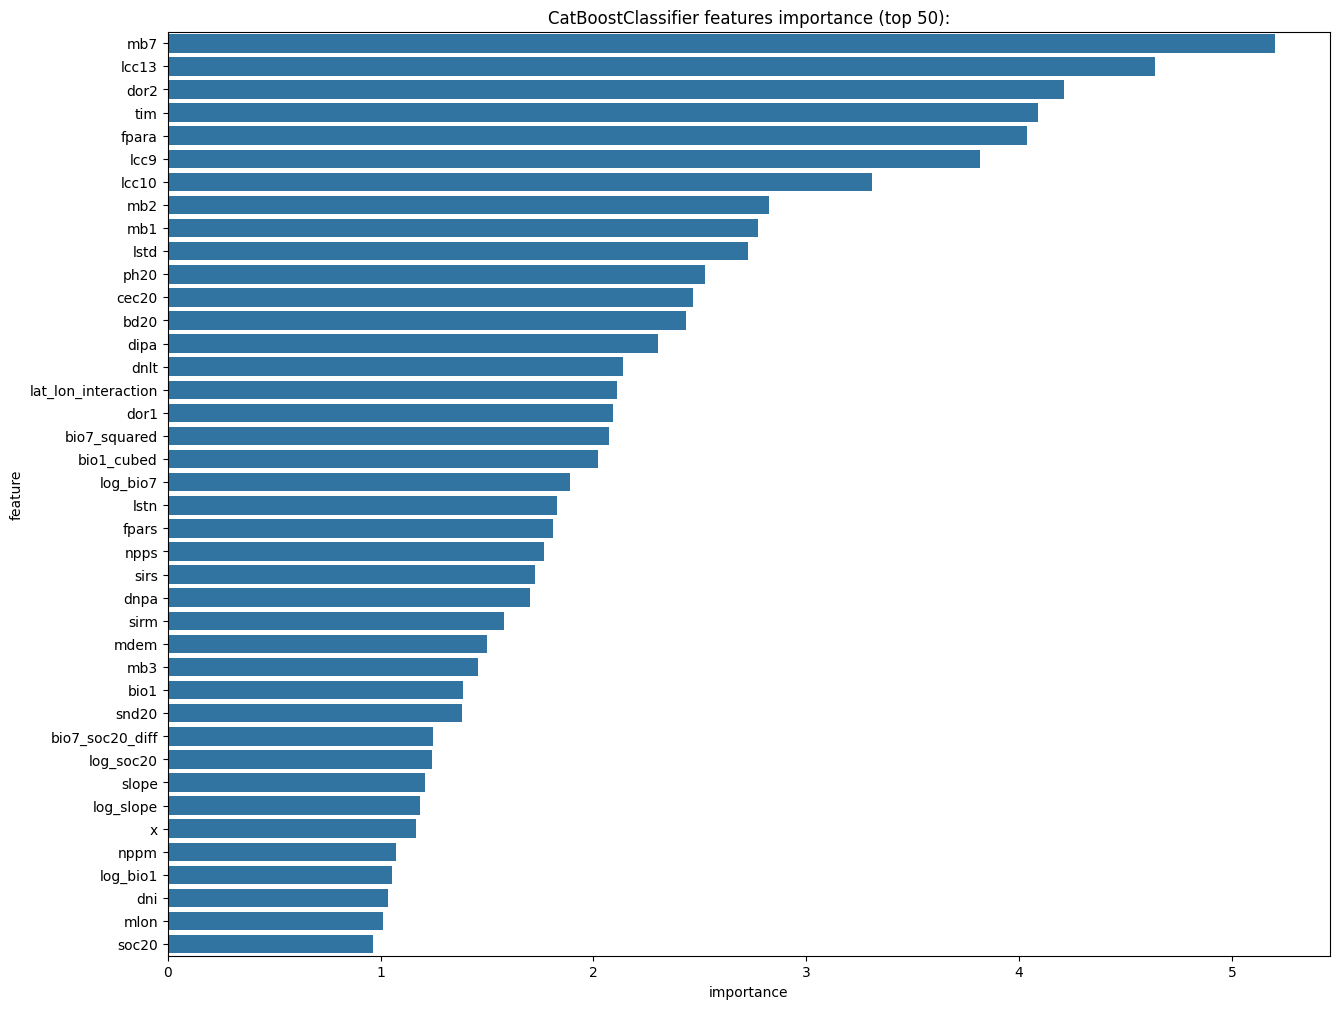

In [36]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = main_cols

plt.figure(figsize=(15, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(40))
plt.title('CatBoostClassifier features importance (top 50):')

In [37]:

if 'bcount' not in test.columns:
    test['bcount'] = 0
X_test = test[main_cols].values

## Training

In [39]:
import optuna
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score


X = train[main_cols].values
y = train[target_cols].values
# X_test = test[main_cols].values

def objective(trial, target_idx):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03, log=True),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 15.0, log=True),
        'random_state': 42,
        'bootstrap_type': 'Bernoulli',
        'verbose': 200
    }

    mskf = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    oof_preds = []
    for train_idx, valid_idx in mskf.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx, target_idx], y[valid_idx, target_idx]

        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        model = CatBoostClassifier(**params, early_stopping_rounds=200)
        model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_valid, y_valid)], verbose=200)

        valid_preds = model.predict_proba(X_valid)[:, 1]
        oof_preds.append(log_loss(y_valid, valid_preds))

    return np.mean(oof_preds)

# Hyperparameter optimization and prediction
test_predictions = {"subid": test["subid"]}

accuracies = []
auc_scores = []


mskf = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for i, target in enumerate(target_cols):
    print(f"Optimizing hyperparameters for {target}...")

    # Run the Optuna study for hyperparameter optimization
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, i), n_trials=5)

    print(f"Best parameters for {target}: {study.best_params}")

    best_params = study.best_params
    best_params.update({'random_state': 42, 'verbose': 200})

    fold_preds = []
    fold_accuracies = []
    fold_auc_scores = []


    # Model training and evaluation
    for train_idx, valid_idx in mskf.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx, i], y[valid_idx, i]

        model = CatBoostClassifier(**best_params, early_stopping_rounds=100)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=200)

        # Make predictions
        valid_preds = model.predict(X_valid)
        valid_probs = model.predict_proba(X_valid)[:, 1]

        # Calculate metrics
        fold_accuracies.append(accuracy_score(y_valid, valid_preds))
        fold_auc_scores.append(roc_auc_score(y_valid, valid_probs))


        # Collect test predictions
        test_preds = model.predict_proba(X_test)[:, 1]
        fold_preds.append(test_preds)

    # Store the metrics for the target
    accuracies.append(np.mean(fold_accuracies))
    auc_scores.append(np.mean(fold_auc_scores))


    # Store the mean test predictions for the target
    test_predictions[target + "_prob"] = np.mean(fold_preds, axis=0)

# Print metrics
print("\nModel Performance Summary:")
for i, target in enumerate(target_cols):
    print(f"Target: {target}")
    print(f"  Accuracy: {accuracies[i]:.4f}")
    print(f"  ROC AUC: {auc_scores[i]:.4f}")

submission_df = pd.DataFrame(test_predictions)
submission_df.to_csv("final_submission.csv", index=False)

[I 2025-03-03 13:42:38,333] A new study created in memory with name: no-name-07c812a3-49cb-456b-b966-722b3cecc7fd


Optimizing hyperparameters for building...
0:	learn: 0.6679063	test: 0.6698537	best: 0.6698537 (0)	total: 398ms	remaining: 8m 25s
200:	learn: 0.0036541	test: 0.0047891	best: 0.0047891 (200)	total: 12.8s	remaining: 1m 8s
400:	learn: 0.0013040	test: 0.0025677	best: 0.0025677 (400)	total: 22s	remaining: 47.7s
600:	learn: 0.0009518	test: 0.0024444	best: 0.0024444 (599)	total: 32.3s	remaining: 35.9s
800:	learn: 0.0007345	test: 0.0024044	best: 0.0024044 (800)	total: 42.6s	remaining: 25s
1000:	learn: 0.0006221	test: 0.0023739	best: 0.0023727 (987)	total: 52.5s	remaining: 14.1s
1200:	learn: 0.0005444	test: 0.0023570	best: 0.0023565 (1195)	total: 1m 2s	remaining: 3.6s
1269:	learn: 0.0005272	test: 0.0023570	best: 0.0023557 (1247)	total: 1m 5s	remaining: 0us

bestTest = 0.002355742847
bestIteration = 1247

Shrink model to first 1248 iterations.
0:	learn: 0.6679454	test: 0.6699126	best: 0.6699126 (0)	total: 57.7ms	remaining: 1m 13s
200:	learn: 0.0036751	test: 0.0049872	best: 0.0049872 (200)	total:

[I 2025-03-03 13:46:26,154] Trial 0 finished with value: 0.0034425920665599 and parameters: {'iterations': 1270, 'learning_rate': 0.0078734960387669, 'depth': 8, 'l2_leaf_reg': 2.5273552073648022}. Best is trial 0 with value: 0.0034425920665599.


1269:	learn: 0.0005777	test: 0.0024754	best: 0.0024729 (1251)	total: 1m 3s	remaining: 0us

bestTest = 0.002472891512
bestIteration = 1251

Shrink model to first 1252 iterations.
0:	learn: 0.6153236	test: 0.6219018	best: 0.6219018 (0)	total: 125ms	remaining: 3m 23s
200:	learn: 0.0005196	test: 0.0024139	best: 0.0024123 (190)	total: 20.5s	remaining: 2m 24s
400:	learn: 0.0003519	test: 0.0023727	best: 0.0023727 (400)	total: 38.5s	remaining: 1m 57s
600:	learn: 0.0003001	test: 0.0023663	best: 0.0023631 (583)	total: 57.2s	remaining: 1m 37s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.002363143129
bestIteration = 583

Shrink model to first 584 iterations.
0:	learn: 0.6150754	test: 0.6202260	best: 0.6202260 (0)	total: 120ms	remaining: 3m 15s
200:	learn: 0.0005431	test: 0.0026365	best: 0.0026291 (192)	total: 19.1s	remaining: 2m 15s
400:	learn: 0.0003333	test: 0.0026008	best: 0.0026008 (378)	total: 36.4s	remaining: 1m 50s
Stopped by overfitting detector  (200 iterations wai

[I 2025-03-03 13:49:43,743] Trial 1 finished with value: 0.003468478229154409 and parameters: {'iterations': 1625, 'learning_rate': 0.024361227762154984, 'depth': 9, 'l2_leaf_reg': 1.4343210847748453}. Best is trial 0 with value: 0.0034425920665599.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.002453587254
bestIteration = 244

Shrink model to first 245 iterations.
0:	learn: 0.6683262	test: 0.6704819	best: 0.6704819 (0)	total: 108ms	remaining: 5m 5s
200:	learn: 0.0033470	test: 0.0046358	best: 0.0046358 (200)	total: 9.72s	remaining: 2m 7s
400:	learn: 0.0010734	test: 0.0025197	best: 0.0025197 (400)	total: 20.5s	remaining: 2m 4s
600:	learn: 0.0006490	test: 0.0023841	best: 0.0023841 (600)	total: 31.4s	remaining: 1m 56s
800:	learn: 0.0004604	test: 0.0023519	best: 0.0023514 (775)	total: 42s	remaining: 1m 46s
1000:	learn: 0.0003919	test: 0.0023424	best: 0.0023424 (1000)	total: 52.1s	remaining: 1m 35s
1200:	learn: 0.0003662	test: 0.0023484	best: 0.0023408 (1036)	total: 1m 2s	remaining: 1m 24s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.002340768357
bestIteration = 1036

Shrink model to first 1037 iterations.
0:	learn: 0.6684363	test: 0.6706931	best: 0.6706931 (0)	total: 71.5ms	remaining: 3m 

[I 2025-03-03 13:54:44,885] Trial 2 finished with value: 0.003386393420721682 and parameters: {'iterations': 2840, 'learning_rate': 0.007352372866721483, 'depth': 8, 'l2_leaf_reg': 1.4300165089592611}. Best is trial 2 with value: 0.003386393420721682.


0:	learn: 0.6095824	test: 0.6179941	best: 0.6179941 (0)	total: 40.2ms	remaining: 1m 47s
200:	learn: 0.0010992	test: 0.0024199	best: 0.0024181 (187)	total: 3.61s	remaining: 44.3s
400:	learn: 0.0007332	test: 0.0023344	best: 0.0023343 (393)	total: 7.01s	remaining: 39.7s
600:	learn: 0.0006428	test: 0.0023051	best: 0.0023050 (597)	total: 10.3s	remaining: 35.6s
800:	learn: 0.0005994	test: 0.0023036	best: 0.0023036 (797)	total: 14.5s	remaining: 33.9s
1000:	learn: 0.0005744	test: 0.0022987	best: 0.0022987 (991)	total: 17.7s	remaining: 29.6s
1200:	learn: 0.0005513	test: 0.0023010	best: 0.0022966 (1054)	total: 20.9s	remaining: 25.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.002296587999
bestIteration = 1054

Shrink model to first 1055 iterations.
0:	learn: 0.6080356	test: 0.6183464	best: 0.6183464 (0)	total: 48.5ms	remaining: 2m 9s
200:	learn: 0.0010903	test: 0.0026089	best: 0.0026079 (198)	total: 4.45s	remaining: 54.7s
400:	learn: 0.0007157	test: 0.0025493	best: 0.002

[I 2025-03-03 13:56:10,653] Trial 3 finished with value: 0.003349935467445804 and parameters: {'iterations': 2671, 'learning_rate': 0.025415683029103724, 'depth': 6, 'l2_leaf_reg': 2.550544814073229}. Best is trial 3 with value: 0.003349935467445804.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.002410801602
bestIteration = 1972

Shrink model to first 1973 iterations.
0:	learn: 0.6737153	test: 0.6750224	best: 0.6750224 (0)	total: 57.7ms	remaining: 2m 23s
200:	learn: 0.0078099	test: 0.0089335	best: 0.0089335 (200)	total: 10.8s	remaining: 2m 2s
400:	learn: 0.0020665	test: 0.0030648	best: 0.0030648 (400)	total: 20.7s	remaining: 1m 47s
600:	learn: 0.0014629	test: 0.0026364	best: 0.0026364 (600)	total: 31s	remaining: 1m 37s
800:	learn: 0.0012530	test: 0.0025527	best: 0.0025526 (797)	total: 41.9s	remaining: 1m 28s
1000:	learn: 0.0011133	test: 0.0025180	best: 0.0025170 (981)	total: 52.1s	remaining: 1m 17s
1200:	learn: 0.0010199	test: 0.0025001	best: 0.0024979 (1166)	total: 1m 2s	remaining: 1m 6s
1400:	learn: 0.0009577	test: 0.0024823	best: 0.0024823 (1400)	total: 1m 12s	remaining: 56s
1600:	learn: 0.0009016	test: 0.0024671	best: 0.0024662 (1590)	total: 1m 21s	remaining: 44.9s
1800:	learn: 0.0008588	test: 0.0024573	b

[I 2025-03-03 14:02:22,357] Trial 4 finished with value: 0.0035068743110609293 and parameters: {'iterations': 2486, 'learning_rate': 0.006351546323094479, 'depth': 8, 'l2_leaf_reg': 4.172837878713026}. Best is trial 3 with value: 0.003349935467445804.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.002512485481
bestIteration = 1319

Shrink model to first 1320 iterations.
Best parameters for building: {'iterations': 2671, 'learning_rate': 0.025415683029103724, 'depth': 6, 'l2_leaf_reg': 2.550544814073229}
0:	learn: 0.6060520	test: 0.6058955	best: 0.6058955 (0)	total: 36.4ms	remaining: 1m 37s
200:	learn: 0.0016289	test: 0.0024716	best: 0.0024673 (196)	total: 3.42s	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.002451731948
bestIteration = 251

Shrink model to first 252 iterations.
0:	learn: 0.6054037	test: 0.6058728	best: 0.6058728 (0)	total: 12.8ms	remaining: 34.2s
200:	learn: 0.0014334	test: 0.0026858	best: 0.0026843 (199)	total: 2.62s	remaining: 32.2s
400:	learn: 0.0004554	test: 0.0025764	best: 0.0025754 (398)	total: 5.25s	remaining: 29.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.002575383698
bestIteration = 398

Shrink model to first 399 iterat

[I 2025-03-03 14:02:44,308] A new study created in memory with name: no-name-e661adce-8dc7-4633-af89-425b766a4511


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.002482205828
bestIteration = 204

Shrink model to first 205 iterations.
Optimizing hyperparameters for cropland...
0:	learn: 0.6888818	test: 0.6894558	best: 0.6894558 (0)	total: 36.5ms	remaining: 44.8s
200:	learn: 0.4740468	test: 0.5224356	best: 0.5224356 (200)	total: 5.99s	remaining: 30.6s
400:	learn: 0.4321242	test: 0.5013007	best: 0.5013007 (400)	total: 11.4s	remaining: 23.5s
600:	learn: 0.4072653	test: 0.4924946	best: 0.4924946 (600)	total: 17.6s	remaining: 18.4s
800:	learn: 0.3866639	test: 0.4864245	best: 0.4864245 (800)	total: 22.7s	remaining: 12.1s
1000:	learn: 0.3671146	test: 0.4813540	best: 0.4813540 (1000)	total: 28.7s	remaining: 6.48s
1200:	learn: 0.3460294	test: 0.4772937	best: 0.4772937 (1200)	total: 33.9s	remaining: 734ms
1226:	learn: 0.3435406	test: 0.4769443	best: 0.4769443 (1226)	total: 34.6s	remaining: 0us

bestTest = 0.4769442719
bestIteration = 1226

0:	learn: 0.6888992	test: 0.6896625	best: 0.6896

[I 2025-03-03 14:05:06,843] Trial 0 finished with value: 0.47315929154999053 and parameters: {'iterations': 1227, 'learning_rate': 0.010529346038863213, 'depth': 7, 'l2_leaf_reg': 4.148712804300738}. Best is trial 0 with value: 0.47315929154999053.


1226:	learn: 0.3429182	test: 0.4748774	best: 0.4748725 (1225)	total: 35.1s	remaining: 0us

bestTest = 0.4748725391
bestIteration = 1225

Shrink model to first 1226 iterations.
0:	learn: 0.6904778	test: 0.6908894	best: 0.6908894 (0)	total: 203ms	remaining: 6m 3s
200:	learn: 0.4876663	test: 0.5332035	best: 0.5332035 (200)	total: 19.4s	remaining: 2m 33s
400:	learn: 0.4358204	test: 0.5062774	best: 0.5062774 (400)	total: 37.2s	remaining: 2m 9s
600:	learn: 0.4059967	test: 0.4954874	best: 0.4954874 (600)	total: 56.4s	remaining: 1m 52s
800:	learn: 0.3834303	test: 0.4891119	best: 0.4891119 (800)	total: 1m 15s	remaining: 1m 33s
1000:	learn: 0.3643783	test: 0.4844199	best: 0.4844199 (1000)	total: 1m 34s	remaining: 1m 15s
1200:	learn: 0.3478849	test: 0.4809456	best: 0.4809456 (1200)	total: 1m 52s	remaining: 56s
1400:	learn: 0.3326376	test: 0.4781388	best: 0.4781388 (1400)	total: 2m 11s	remaining: 37.1s
1600:	learn: 0.3166818	test: 0.4758261	best: 0.4758241 (1599)	total: 2m 30s	remaining: 18.3s
179

[I 2025-03-03 14:16:19,727] Trial 1 finished with value: 0.4705369796662794 and parameters: {'iterations': 1796, 'learning_rate': 0.006169494766688457, 'depth': 9, 'l2_leaf_reg': 3.777342284650646}. Best is trial 1 with value: 0.4705369796662794.


1795:	learn: 0.3003410	test: 0.4728371	best: 0.4728371 (1795)	total: 2m 43s	remaining: 0us

bestTest = 0.4728370557
bestIteration = 1795

0:	learn: 0.6812427	test: 0.6829227	best: 0.6829227 (0)	total: 118ms	remaining: 2m 15s
200:	learn: 0.3841008	test: 0.4894179	best: 0.4894179 (200)	total: 18s	remaining: 1m 25s
400:	learn: 0.3154578	test: 0.4778424	best: 0.4778424 (400)	total: 36.9s	remaining: 1m 9s
600:	learn: 0.2561155	test: 0.4737776	best: 0.4737776 (600)	total: 55.5s	remaining: 50.9s
800:	learn: 0.2130520	test: 0.4729881	best: 0.4729695 (798)	total: 1m 15s	remaining: 32.9s
1000:	learn: 0.1791370	test: 0.4733880	best: 0.4725922 (880)	total: 1m 33s	remaining: 14.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4725921757
bestIteration = 880

Shrink model to first 881 iterations.
0:	learn: 0.6810547	test: 0.6831307	best: 0.6831307 (0)	total: 105ms	remaining: 2m
200:	learn: 0.3880426	test: 0.4802744	best: 0.4802744 (200)	total: 19.1s	remaining: 1m 30s
400:	learn

[I 2025-03-03 14:23:05,090] Trial 2 finished with value: 0.4662577069970314 and parameters: {'iterations': 1152, 'learning_rate': 0.028778171394422992, 'depth': 9, 'l2_leaf_reg': 8.85173774950504}. Best is trial 2 with value: 0.4662577069970314.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4688902956
bestIteration = 837

Shrink model to first 838 iterations.
0:	learn: 0.6844439	test: 0.6858848	best: 0.6858848 (0)	total: 134ms	remaining: 4m 15s
200:	learn: 0.3863423	test: 0.4909895	best: 0.4909895 (200)	total: 29.8s	remaining: 4m 12s
400:	learn: 0.3205230	test: 0.4791925	best: 0.4791925 (400)	total: 57.9s	remaining: 3m 36s
600:	learn: 0.2648788	test: 0.4741046	best: 0.4741019 (599)	total: 1m 26s	remaining: 3m 6s
800:	learn: 0.2174546	test: 0.4708143	best: 0.4708143 (800)	total: 1m 54s	remaining: 2m 37s
1000:	learn: 0.1818969	test: 0.4703125	best: 0.4703125 (1000)	total: 2m 23s	remaining: 2m 8s
1200:	learn: 0.1522908	test: 0.4718798	best: 0.4701833 (1006)	total: 2m 51s	remaining: 1m 40s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4701833143
bestIteration = 1006

Shrink model to first 1007 iterations.
0:	learn: 0.6842047	test: 0.6857785	best: 0.6857785 (0)	total: 143ms	remaining: 4

[I 2025-03-03 14:35:09,089] Trial 3 finished with value: 0.4655640598299068 and parameters: {'iterations': 1902, 'learning_rate': 0.020039609340834406, 'depth': 10, 'l2_leaf_reg': 6.265744274221712}. Best is trial 3 with value: 0.4655640598299068.


0:	learn: 0.6895934	test: 0.6901065	best: 0.6901065 (0)	total: 57.8ms	remaining: 1m 23s
200:	learn: 0.4734130	test: 0.5240054	best: 0.5240054 (200)	total: 9.35s	remaining: 57.9s
400:	learn: 0.4262982	test: 0.5012230	best: 0.5012230 (400)	total: 19.4s	remaining: 50.4s
600:	learn: 0.3974521	test: 0.4916609	best: 0.4916609 (600)	total: 29.7s	remaining: 41.7s
800:	learn: 0.3748410	test: 0.4859260	best: 0.4859260 (800)	total: 39.8s	remaining: 32s
1000:	learn: 0.3550150	test: 0.4817041	best: 0.4817041 (1000)	total: 49.9s	remaining: 22.2s
1200:	learn: 0.3355139	test: 0.4783633	best: 0.4783633 (1200)	total: 1m	remaining: 12.2s
1400:	learn: 0.3153642	test: 0.4752615	best: 0.4752545 (1399)	total: 1m 9s	remaining: 2.18s
1444:	learn: 0.3108718	test: 0.4746049	best: 0.4745890 (1443)	total: 1m 12s	remaining: 0us

bestTest = 0.4745889803
bestIteration = 1443

Shrink model to first 1444 iterations.
0:	learn: 0.6894105	test: 0.6901719	best: 0.6901719 (0)	total: 75.5ms	remaining: 1m 49s
200:	learn: 0.47

[I 2025-03-03 14:40:00,105] Trial 4 finished with value: 0.4704993054370068 and parameters: {'iterations': 1445, 'learning_rate': 0.008341825952603231, 'depth': 8, 'l2_leaf_reg': 1.6141612809756565}. Best is trial 3 with value: 0.4655640598299068.


1444:	learn: 0.3100158	test: 0.4724970	best: 0.4724840 (1443)	total: 1m 12s	remaining: 0us

bestTest = 0.4724839905
bestIteration = 1443

Shrink model to first 1444 iterations.
Best parameters for cropland: {'iterations': 1902, 'learning_rate': 0.020039609340834406, 'depth': 10, 'l2_leaf_reg': 6.265744274221712}
0:	learn: 0.6845206	test: 0.6852055	best: 0.6852055 (0)	total: 107ms	remaining: 3m 22s
200:	learn: 0.4019424	test: 0.4705570	best: 0.4705570 (200)	total: 24.6s	remaining: 3m 28s
400:	learn: 0.3425033	test: 0.4616777	best: 0.4616777 (400)	total: 48.6s	remaining: 3m 2s
600:	learn: 0.2894806	test: 0.4595509	best: 0.4593868 (594)	total: 1m 12s	remaining: 2m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4593490057
bestIteration = 615

Shrink model to first 616 iterations.
0:	learn: 0.6854102	test: 0.6856104	best: 0.6856104 (0)	total: 109ms	remaining: 3m 28s
200:	learn: 0.4069310	test: 0.4611017	best: 0.4611017 (200)	total: 23.9s	remaining: 3m 22s
400:	lear

[I 2025-03-03 14:46:17,462] A new study created in memory with name: no-name-b8b01a06-1fe8-47fd-8dc3-4ba4528c2974


Optimizing hyperparameters for wcover...
0:	learn: 0.6915920	test: 0.6916358	best: 0.6916358 (0)	total: 116ms	remaining: 3m 58s
200:	learn: 0.5568870	test: 0.5733637	best: 0.5733637 (200)	total: 17.4s	remaining: 2m 41s
400:	learn: 0.5181561	test: 0.5514687	best: 0.5514687 (400)	total: 35.6s	remaining: 2m 27s
600:	learn: 0.4942933	test: 0.5431069	best: 0.5431069 (600)	total: 53.4s	remaining: 2m 9s
800:	learn: 0.4756120	test: 0.5383975	best: 0.5383975 (800)	total: 1m 11s	remaining: 1m 52s
1000:	learn: 0.4589781	test: 0.5355527	best: 0.5355527 (1000)	total: 1m 29s	remaining: 1m 34s
1200:	learn: 0.4432673	test: 0.5330572	best: 0.5330572 (1200)	total: 1m 47s	remaining: 1m 17s
1400:	learn: 0.4279609	test: 0.5310808	best: 0.5310670 (1399)	total: 2m 5s	remaining: 59.3s
1600:	learn: 0.4126649	test: 0.5296931	best: 0.5296931 (1600)	total: 2m 23s	remaining: 41.5s
1800:	learn: 0.3971947	test: 0.5283121	best: 0.5282958 (1799)	total: 2m 40s	remaining: 23.3s
2000:	learn: 0.3823104	test: 0.5274778	bes

[I 2025-03-03 14:58:32,264] Trial 0 finished with value: 0.5354810499030409 and parameters: {'iterations': 2062, 'learning_rate': 0.006621802893156641, 'depth': 9, 'l2_leaf_reg': 9.382207174598319}. Best is trial 0 with value: 0.5354810499030409.


0:	learn: 0.6919265	test: 0.6919498	best: 0.6919498 (0)	total: 20.6ms	remaining: 21.3s
200:	learn: 0.5813240	test: 0.5880203	best: 0.5880203 (200)	total: 3.04s	remaining: 12.6s
400:	learn: 0.5507701	test: 0.5634545	best: 0.5634545 (400)	total: 5.91s	remaining: 9.32s
600:	learn: 0.5354314	test: 0.5536048	best: 0.5536048 (600)	total: 8.86s	remaining: 6.38s
800:	learn: 0.5246256	test: 0.5482710	best: 0.5482710 (800)	total: 12.7s	remaining: 3.7s
1000:	learn: 0.5159292	test: 0.5445861	best: 0.5445861 (1000)	total: 15.9s	remaining: 524ms
1033:	learn: 0.5145416	test: 0.5441300	best: 0.5441300 (1033)	total: 16.4s	remaining: 0us

bestTest = 0.5441300267
bestIteration = 1033

0:	learn: 0.6920229	test: 0.6920562	best: 0.6920562 (0)	total: 14.1ms	remaining: 14.6s
200:	learn: 0.5799412	test: 0.5880052	best: 0.5880052 (200)	total: 2.98s	remaining: 12.4s
400:	learn: 0.5488609	test: 0.5649542	best: 0.5649542 (400)	total: 6.96s	remaining: 11s
600:	learn: 0.5325565	test: 0.5563549	best: 0.5563549 (600)	

[I 2025-03-03 14:59:41,906] Trial 1 finished with value: 0.5491224193716923 and parameters: {'iterations': 1034, 'learning_rate': 0.005572678254582881, 'depth': 6, 'l2_leaf_reg': 1.1804721739506028}. Best is trial 0 with value: 0.5354810499030409.


1033:	learn: 0.5077029	test: 0.5605528	best: 0.5605528 (1033)	total: 16.5s	remaining: 0us

bestTest = 0.5605528114
bestIteration = 1033

0:	learn: 0.6912137	test: 0.6912807	best: 0.6912807 (0)	total: 224ms	remaining: 4m 17s
200:	learn: 0.5422300	test: 0.5645396	best: 0.5645396 (200)	total: 17.8s	remaining: 1m 24s
400:	learn: 0.5014342	test: 0.5460663	best: 0.5460663 (400)	total: 35.1s	remaining: 1m 5s
600:	learn: 0.4747250	test: 0.5389171	best: 0.5389171 (600)	total: 53.8s	remaining: 49s
800:	learn: 0.4518476	test: 0.5343820	best: 0.5343820 (800)	total: 1m 10s	remaining: 30.6s
1000:	learn: 0.4316966	test: 0.5317890	best: 0.5317888 (995)	total: 1m 28s	remaining: 13.1s
1147:	learn: 0.4169990	test: 0.5305173	best: 0.5305173 (1147)	total: 1m 42s	remaining: 0us

bestTest = 0.5305173396
bestIteration = 1147

0:	learn: 0.6913635	test: 0.6914538	best: 0.6914538 (0)	total: 101ms	remaining: 1m 56s
200:	learn: 0.5384287	test: 0.5657706	best: 0.5657706 (200)	total: 16.6s	remaining: 1m 18s
400:	lea

[I 2025-03-03 15:06:29,385] Trial 2 finished with value: 0.5378179038925629 and parameters: {'iterations': 1148, 'learning_rate': 0.008078216144948691, 'depth': 9, 'l2_leaf_reg': 5.558166553360279}. Best is trial 0 with value: 0.5354810499030409.


1147:	learn: 0.4106373	test: 0.5507119	best: 0.5507025 (1146)	total: 1m 41s	remaining: 0us

bestTest = 0.5507024746
bestIteration = 1146

Shrink model to first 1147 iterations.
0:	learn: 0.6897025	test: 0.6898742	best: 0.6898742 (0)	total: 52.9ms	remaining: 1m 37s
200:	learn: 0.5140556	test: 0.5493129	best: 0.5493129 (200)	total: 9.79s	remaining: 1m 20s
400:	learn: 0.4716269	test: 0.5379340	best: 0.5379340 (400)	total: 19.5s	remaining: 1m 10s
600:	learn: 0.4378851	test: 0.5332538	best: 0.5332538 (600)	total: 28.2s	remaining: 58.7s
800:	learn: 0.4047343	test: 0.5298855	best: 0.5298695 (798)	total: 37.7s	remaining: 49.5s
1000:	learn: 0.3705901	test: 0.5279958	best: 0.5278745 (979)	total: 47.6s	remaining: 40.4s
1200:	learn: 0.3397991	test: 0.5266503	best: 0.5265603 (1197)	total: 56.8s	remaining: 30.8s
1400:	learn: 0.3127885	test: 0.5262331	best: 0.5260247 (1315)	total: 1m 6s	remaining: 21.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5260246539
bestIteration = 13

[I 2025-03-03 15:11:07,489] Trial 3 finished with value: 0.5346798996750335 and parameters: {'iterations': 1851, 'learning_rate': 0.01444381877287126, 'depth': 8, 'l2_leaf_reg': 1.1613875293439528}. Best is trial 3 with value: 0.5346798996750335.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5495476865
bestIteration = 1008

Shrink model to first 1009 iterations.
0:	learn: 0.6881845	test: 0.6882245	best: 0.6882245 (0)	total: 15.3ms	remaining: 33.7s
200:	learn: 0.5259162	test: 0.5475003	best: 0.5475003 (200)	total: 3.12s	remaining: 31.2s
400:	learn: 0.4972078	test: 0.5377907	best: 0.5377907 (400)	total: 7.27s	remaining: 32.8s
600:	learn: 0.4685076	test: 0.5323836	best: 0.5323836 (600)	total: 10.3s	remaining: 27.7s
800:	learn: 0.4432830	test: 0.5288562	best: 0.5288562 (800)	total: 13.5s	remaining: 23.7s
1000:	learn: 0.4217078	test: 0.5271383	best: 0.5271260 (987)	total: 17.7s	remaining: 21.4s
1200:	learn: 0.4021978	test: 0.5258774	best: 0.5258774 (1200)	total: 20.7s	remaining: 17.4s
1400:	learn: 0.3842426	test: 0.5253804	best: 0.5252639 (1368)	total: 23.8s	remaining: 13.7s
1600:	learn: 0.3681530	test: 0.5249736	best: 0.5249281 (1597)	total: 26.8s	remaining: 10.2s
1800:	learn: 0.3522879	test: 0.5246810	best: 

[I 2025-03-03 15:13:03,204] Trial 4 finished with value: 0.5347910485458756 and parameters: {'iterations': 2211, 'learning_rate': 0.023771146257042998, 'depth': 6, 'l2_leaf_reg': 9.21207168198003}. Best is trial 3 with value: 0.5346798996750335.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5493855905
bestIteration = 1120

Shrink model to first 1121 iterations.
Best parameters for wcover: {'iterations': 1851, 'learning_rate': 0.01444381877287126, 'depth': 8, 'l2_leaf_reg': 1.1613875293439528}
0:	learn: 0.6897192	test: 0.6898862	best: 0.6898862 (0)	total: 49.7ms	remaining: 1m 31s
200:	learn: 0.5190045	test: 0.5463585	best: 0.5463585 (200)	total: 7.44s	remaining: 1m 1s
400:	learn: 0.4792767	test: 0.5346585	best: 0.5346307 (399)	total: 15.8s	remaining: 57s
600:	learn: 0.4477513	test: 0.5298137	best: 0.5298076 (599)	total: 24s	remaining: 50s
800:	learn: 0.4129334	test: 0.5263093	best: 0.5262677 (770)	total: 31.6s	remaining: 41.4s
1000:	learn: 0.3774401	test: 0.5247142	best: 0.5246780 (997)	total: 39.9s	remaining: 33.9s
1200:	learn: 0.3480575	test: 0.5243308	best: 0.5242987 (1198)	total: 48s	remaining: 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5242986923
bestIteration = 1198

Sh

In [40]:
submission_df.head()

subid  building_prob  cropland_prob  wcover_prob
15856  1548905       0.000210       0.498082     0.894988
15857  1548829       0.000206       0.200002     0.797343
15858  1548811       0.000207       0.035230     0.885545
15859  1548806       0.000147       0.741779     0.813428
15860  1548798       0.000288       0.822484     0.799759